# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import pandas as pd
df = pd.read_csv('Gazprom/texts.csv', parse_dates=['date'], dayfirst=True,index_col='date')

In [2]:
df.sort_index(ascending=True, inplace=True)
df.head(3)

,text
date,
2010-01-04,
2010-01-11,Спорные вопросы по оплате за оказанные в пери...
2010-01-19,"""Газпром"" готов забирать весь объем азербайдж..."


In [3]:
pr_all = pd.read_csv('Gazprom/gazprom_prices.csv', sep=';', decimal=',', parse_dates=['Date'],
                    dayfirst=True, index_col='Date')

In [4]:
pr_all.sort_index(ascending=True, inplace=True)
pr_all.head(3)

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
Date,,,,,
2010-01-11,192.50,194.5,196.90,191.00,59815603
2010-01-12,194.00,191.8,195.80,190.55,43482579
2010-01-13,189.72,189.3,191.86,188.30,52416087


In [5]:
import re
import nltk
import pymorphy2 
import pymystem3
import codecs
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import bokeh
import seaborn as sns
import random
from pylab import pcolor, show, colorbar, xticks, yticks

%matplotlib inline

D:\Anaconda\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
df.info(), df.shape 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2010-01-04 to 2017-11-09
Data columns (total 1 columns):
text    1203 non-null object
dtypes: object(1)
memory usage: 18.8+ KB


(None, (1203, 1))

In [7]:
pr_all.info(), pr_all.shape 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1988 entries, 2010-01-11 to 2017-12-08
Data columns (total 5 columns):
Open            1964 non-null float64
ClosingPrice    1988 non-null float64
DailyHigh       1986 non-null float64
DailyLow        1986 non-null float64
VolumePcs       1988 non-null int64
dtypes: float64(4), int64(1)
memory usage: 93.2 KB


(None, (1988, 5))

### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

###### Токенизация и приведение к нижнему регистру

In [8]:
import re
regex = re.compile("[А-Яа-я----]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

In [9]:
df.text.iloc[:10]

date
2010-01-04                                                     
2010-01-11    спорные вопросы по оплате за оказанные в перио...
2010-01-19    газпром готов забирать весь объем азербайджанс...
2010-01-28    консорциум во главе с российским оао газпром н...
2010-02-01    газпром не исключает в г выпуска облигаций при...
2010-02-03    переговоры оао газпром с оператором проекта са...
2010-02-04    российский газовый монополист компания газпром...
2010-02-15    российский газпром сообщил о планах увеличения...
2010-03-10    подконтрольный газпрому нефтедобытчик газпром ...
2010-03-22    газпром назвал участников конкурса по отбору о...
Name: text, dtype: object

###### Удаление стоп-слов

In [10]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['оао','руб', 'евро', 'долл', 'тыс', 'млн', 'млрд', 'также',
                                            'это', 'наш', 'т', 'д', '-', '-', 'вице', 'эль', 'г', 'ъ']

print(mystopwords)
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
df.text = df.text.apply(remove_stopwords) 

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

###### Лемматизация

In [11]:
%%time 
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

Wall time: 27min 17s


In [12]:
df.text

date
2010-01-04                                                     
2010-01-11    спорный вопрос оплата оказывать период гг услу...
2010-01-19    газпром готовый забирать весь объем азербайджа...
2010-01-28    консорциум глава российский газпром нефть четв...
2010-02-01    газпром исключать выпуск облигация примерно по...
2010-02-03    переговоры газпром оператор проект сахалин- ко...
2010-02-04    российский газовый монополист компания газпром...
2010-02-15    российский газпром сообщать план увеличение до...
2010-03-10    подконтрольный газпром нефтедобытчик газпром н...
2010-03-22    газпром называть участник конкурс отбор органи...
2010-03-26    глава газпром новатэк леонид михельсон алексей...
2010-03-30    итог чистый прибыль газпром нефть рсба выраста...
2010-03-31    сегодня пройти годовой собрание акционер белор...
2010-04-07    украина полностью расплачиваться мартовский по...
2010-04-12    крупный мир производитель газ газпром договари...
2010-04-19    министр природный рес

###### Проверяем, есть ли корреляция между длиной текстов и ценой закрытия, графически и численно

In [13]:
df['len_data'] = df.text.apply(len)

In [14]:
intersection = pr_all.join(df, how='inner')

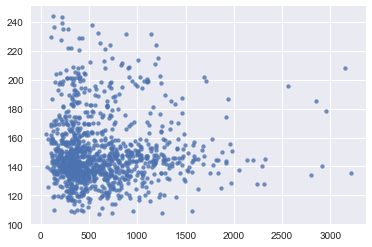

In [15]:
plt.scatter(x=intersection.len_data, y=intersection.ClosingPrice, alpha=0.8, s=15.2)

In [16]:
from scipy import stats
x = intersection.len_data
y = intersection.ClosingPrice
corr = {}
corr['pearson'], _ = stats.pearsonr(x,y)
corr['spearman'], _ = stats.spearmanr(x,y)
corr['kendall'], _ = stats.kendalltau(x,y)

print(corr)

{'pearson': 0.012273956759408979, 'spearman': -0.008241392638395996, 'kendall': -0.0060826355701091303}


In [17]:
# Можно сделать вывод о том что корреляция не наблюдается

###### Проверяем, есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия

In [18]:
prog = re.compile(r'миллер')
df['Miller'] = df.text.apply(prog.findall)
df['Miller_count'] = df.Miller.apply(len)

In [19]:
intersection = pr_all.join(df, how='inner')

In [20]:
x = intersection.Miller_count
y = intersection.ClosingPrice
corr = {}
corr['pearson'], _ = stats.pearsonr(x,y)
corr['spearman'], _ = stats.spearmanr(x,y)
corr['kendall'], _ = stats.kendalltau(x,y)

print(corr)

{'pearson': 0.010635076467578013, 'spearman': 0.023244353525710616, 'kendall': 0.018954081964142402}


In [ ]:
# Можно сделать вывод о том что корреляция не наблюдается

###### Проверяем упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"

In [21]:
prog = re.compile(r'северный поток')
df['north_stream'] = df.text.apply(prog.findall)
df['north_stream_count'] = df.north_stream.apply(len)

prog = re.compile(r'турецкий поток')
df['turkish_stream'] = df.text.apply(prog.findall)
df['turkish_stream_count'] = df.turkish_stream.apply(len)

north_stream_mentioned = df.north_stream_count.sum()
turkish_stream_mentioned = df.turkish_stream_count.sum()

north_stream_mentioned, turkish_stream_mentioned

(15, 39)

In [22]:
# Можно сделать вывод о том число упоминаний проекта Турецкий поток больше

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

###### Бинаризируем признак изменения цены закрытия и разбиваем выборку на обучающую и тестовую

In [23]:
p_data = pr_all[['ClosingPrice']]

In [24]:
p_data.head(3)

,ClosingPrice
Date,
2010-01-11,194.5
2010-01-12,191.8
2010-01-13,189.3


In [25]:
change_data = pd.DataFrame(p_data.ClosingPrice / p_data.ClosingPrice.shift(1))
change_data.head(3)

,ClosingPrice
Date,
2010-01-11,NaN
2010-01-12,0.986118
2010-01-13,0.986966


In [26]:
change_data.rename(columns={'ClosingPrice' : 'Change'}, inplace=True)
p_data = pd.concat([p_data, change_data], axis = 1)
p_data.head(4)

,ClosingPrice,Change
Date,,
2010-01-11,194.50,NaN
2010-01-12,191.80,0.986118
2010-01-13,189.30,0.986966
2010-01-14,190.83,1.008082


In [27]:
p_data.dropna(inplace=True)

In [29]:
p_data.head(4)

,ClosingPrice,Change
Date,,
2010-01-12,191.80,0.986118
2010-01-13,189.30,0.986966
2010-01-14,190.83,1.008082
2010-01-15,187.86,0.984436


In [30]:
p_data['ClosingPrice_bin'] = (p_data.Change // 1).astype(dtype='int')
p_data.head(3)


,ClosingPrice,Change,ClosingPrice_bin
Date,,,
2010-01-12,191.80,0.986118,0
2010-01-13,189.30,0.986966,0
2010-01-14,190.83,1.008082,1


In [32]:
df = df[['text']]

In [33]:
intersection = p_data.join(df, how='inner')

In [42]:
intersection.head(2)

,ClosingPrice,Change,ClosingPrice_bin,text
2010-01-19,189.76,0.996639,0,газпром готовый забирать весь объем азербайджа...
2010-01-28,182.30,1.001593,1,консорциум глава российский газпром нефть четв...


In [35]:
intersection.ClosingPrice_bin.value_counts(normalize=True)

0    0.51209
1    0.48791
Name: ClosingPrice_bin, dtype: float64

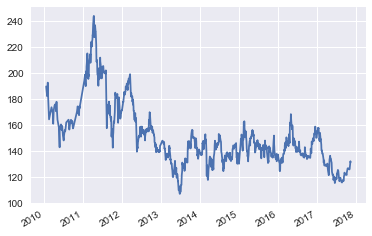

In [40]:
intersection.ClosingPrice.plot()

In [54]:
data_train = intersection[:'2015']
data_test = intersection['2016':]

In [59]:
X_train = data_train['text']
y_train = data_train['ClosingPrice_bin']
X_test = data_test['text']
y_test = data_test['ClosingPrice_bin']

###### Используем CountVectorizer и строим базовые классификаторы с сеточным подбором гиперпараметров, проверяем возможность улучшения с помощью tf-idf преобразования и снижения размерности

In [631]:
import random
random.seed(2904)
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD

In [336]:
X_train_list = X_train.tolist()
vect = CountVectorizer(ngram_range=(1,4))
X_train_counts = vect.fit_transform(X_train_list)
X_train_counts.shape

(900, 154790)

In [337]:
X_test_list = X_test.tolist()
X_test_counts = vect.transform(X_test_list)
X_test_counts.shape

(258, 154790)

In [534]:
classifier = LogisticRegression(random_state=2904)

In [535]:
classifier.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2904, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [536]:
params = {'C': [.1, .2, .3, .4, .5, 1]}

In [537]:
clf = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', verbose=5)

In [538]:
%%time
clf.fit(X_train_counts, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1 ...........................................................
[CV] ................................ C=0.1, score=0.48, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] C=0.1 ...........................................................
[CV] ................................ C=0.1, score=0.51, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] C=0.1 ...........................................................
[CV] ................. C=0.1, score=0.49333333333333335, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] C=0.2 ...........................................................
[CV] ................. C=0.2, score=0.47333333333333333, total=   0.1s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV] C=0.2 ...........................................................
[CV] .................. C=0.2, score=0.5033333333333333, total=   0.1s
[CV] C=0.2 ...........................................................
[CV] .................. C=0.2, score=0.4866666666666667, total=   0.1s
[CV] C=0.3 ...........................................................
[CV] ................................ C=0.3, score=0.47, total=   0.2s
[CV] C=0.3 ...........................................................
[CV] .................. C=0.3, score=0.5033333333333333, total=   0.2s
[CV] C=0.3 ...........................................................
[CV] .................. C=0.3, score=0.4866666666666667, total=   0.2s
[CV] C=0.4 ...........................................................
[CV] ................................ C=0.4, score=0.47, total=   0.2s
[CV] C=0.4 ...........................................................
[CV] .................. C=0.4, score=0.5033333333333333, total=   0.2s
[CV] C

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.9s finished


Wall time: 5.33 s


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2904, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [539]:
clf.best_score_

0.49444444444444446

In [540]:
predictions = clf.predict(X_test_counts)

Precision:   0.46
Recall:   0.46
F1-measure:   0.46
Accuracy:   0.46
             precision    recall  f1-score   support

          0       0.50      0.42      0.46       140
          1       0.42      0.50      0.46       118

avg / total       0.46      0.46      0.46       258



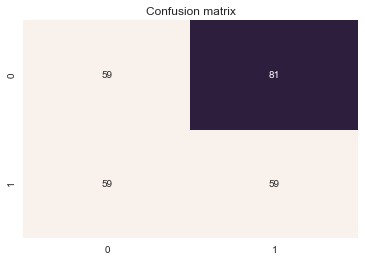

In [541]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [542]:
transformer = TfidfTransformer()
reducer = TruncatedSVD(n_components=30)

In [543]:
a = transformer.fit_transform(X_train_counts)
b = reducer.fit_transform(a)
c = transformer.fit_transform(X_test_counts)
d = reducer.fit_transform(c)

In [544]:
clf = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', verbose=5)

In [545]:
clf.fit(b, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.5033333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.1 ...........................................................
[CV] ................. C=0.1, score=0.48333333333333334, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.1 ...........................................................
[CV] ................................. C=0.1, score=0.5, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.2 ...........................................................
[CV] ................. C=0.2, score=0.48333333333333334, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.2 ...........................................................
[CV] .................. C=0.2, score=0.4666666666666667, total=   0.0s
[CV] C=0.2 ...........................................................
[CV] .................. C=0.2, score=0.5166666666666667, total=   0.0s
[CV] C=0.3 ...........................................................
[CV] .................. C=0.3, score=0.4866666666666667, total=   0.0s
[CV] C=0.3 ...........................................................
[CV] .................. C=0.3, score=0.4633333333333333, total=   0.0s
[CV] C=0.3 ...........................................................
[CV] .................. C=0.3, score=0.5033333333333333, total=   0.0s
[CV] C=0.4 ...........................................................
[CV] ................. C=0.4, score=0.49333333333333335, total=   0.0s
[CV] C=0.4 ...........................................................
[CV] ................................ C=0.4, score=0.48, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2904, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [546]:
clf.best_score_

0.49555555555555558

In [547]:
predictions = clf.predict(d)

Precision:   0.48
Recall:   0.49
F1-measure:   0.46
Accuracy:   0.51
             precision    recall  f1-score   support

          0       0.54      0.76      0.63       140
          1       0.43      0.21      0.28       118

avg / total       0.49      0.51      0.47       258



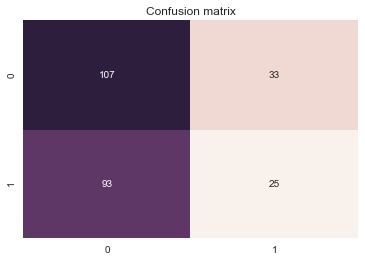

In [548]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [549]:
classifier = MultinomialNB()

classifier.get_params

<bound method BaseEstimator.get_params of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)>

In [550]:
params = {'alpha': [.001, .01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}

In [551]:
clf = GridSearchCV(estimator=classifier, param_grid=params, verbose=5, scoring='accuracy')

In [552]:
%%time
clf.fit(X_train_counts, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] alpha=0.001 .....................................................
[CV] .......................... alpha=0.001, score=0.56, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ........................... alpha=0.001, score=0.5, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.5533333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ............. alpha=0.01, score=0.5433333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ............................ alpha=0.01, score=0.5, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............. alpha=0.01, score=0.5333333333333333, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............................ alpha=0.1, score=0.53, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=0.49333333333333335, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............................ alpha=0.1, score=0.51, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] .............. alpha=0.2, score=0.5333333333333333, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ............. alpha=0.2, score=0.47333333333333333, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.5s finished


Wall time: 1.62 s


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [553]:
clf.best_score_, clf.best_params_

(0.5377777777777778, {'alpha': 0.001})

In [554]:
predictions = clf.predict(X_test_counts)

Precision:   0.53
Recall:   0.53
F1-measure:   0.53
Accuracy:   0.54
             precision    recall  f1-score   support

          0       0.57      0.59      0.58       140
          1       0.50      0.48      0.49       118

avg / total       0.54      0.54      0.54       258



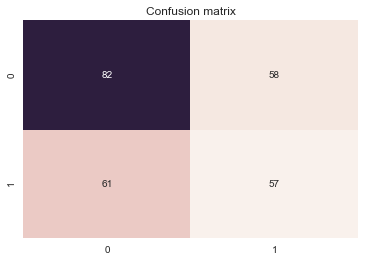

In [555]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [556]:
clf = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', verbose=5)

In [558]:
clf.fit(a, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.5433333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.5266666666666666, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.5233333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ............. alpha=0.01, score=0.5566666666666666, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ............. alpha=0.01, score=0.5066666666666667, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............ alpha=0.01, score=0.49666666666666665, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............................ alpha=0.1, score=0.55, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=0.48333333333333334, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............................. alpha=0.1, score=0.5, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ............................ alpha=0.2, score=0.54, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ............. alpha=0.2, score=0.49333333333333335, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [559]:
clf.best_score_, clf.best_params_

(0.53111111111111109, {'alpha': 0.001})

In [560]:
predictions = clf.predict(c)

Precision:   0.52
Recall:   0.53
F1-measure:   0.52
Accuracy:   0.53
             precision    recall  f1-score   support

          0       0.57      0.55      0.56       140
          1       0.48      0.50      0.49       118

avg / total       0.53      0.53      0.53       258



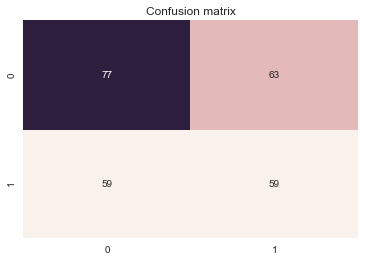

In [561]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [566]:
classifier = SGDClassifier(random_state=2904, verbose=5)

In [567]:
classifier.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=2904,
       shuffle=True, tol=None, verbose=5, warm_start=False)>

In [568]:
params = {'alpha' : [.0001, .005, .01, .05, .1, .5 ]}

In [571]:
clf = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy')

In [572]:
%%time
clf.fit(X_train_counts, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 2048.06, NNZs: 60859, Bias: 0.728416, T: 600, Avg. loss: 171.457419
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1740.36, NNZs: 84105, Bias: -0.134857, T: 1200, Avg. loss: 52.240329
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1430.22, NNZs: 90263, Bias: 0.162531, T: 1800, Avg. loss: 11.850746
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1192.42, NNZs: 92359, Bias: 0.189633, T: 2400, Avg. loss: 1.310534
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 1022.04, NNZs: 93435, Bias: 0.192008, T: 3000, Avg. loss: 0.244672
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 2088.21, NNZs: 62606, Bias: -0.285101, T: 600, Avg. loss: 175.540390
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1754.42, NNZs: 81220, Bias: -0.305642, T: 1200, Avg. loss: 44.949547
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1448.24, NNZs: 86905, Bias: -0.033108, T: 1800, Avg. loss: 8.729869
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1214.10, NNZs: 89051, Bias: 0.125970, T: 2400, Avg. loss: 2.246413
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1036.08, NNZs: 89541, Bias: 0.180224, T: 3000, Avg. loss: 0.656722
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1962.87, NNZs: 51464, Bias: 0.973087, T: 600, Avg. loss: 155.000910
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1689.26, NNZs: 71776, Bias: 0.688266, T: 1200, Avg. loss: 57.393935
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1413.88, NNZs: 79214, Bias: 0.758486, T: 1800, Avg. loss: 9.128900
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1183.43, NNZs: 81919, Bias: 0.855145, T: 2400, Avg. loss: 2.422301
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 1014.45, NNZs: 83024, Bias: 0.882336, T: 3000, Avg. loss: 0.506741
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 101.80, NNZs: 63032, Bias: 0.139221, T: 600, Avg. loss: 16.751760
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 60.90, NNZs: 84018, Bias: 0.130859, T: 1200, Avg. loss: 2.139186
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 43.44, NNZs: 90575, Bias: 0.134046, T: 1800, Avg. loss: 0.309152
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 33.57, NNZs: 94696, Bias: 0.133605, T: 2400, Avg. loss: 0.094375
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 27.39, NNZs: 96872, Bias: 0.135181, T: 3000, Avg. loss: 0.023405
Total training time: 0.08 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 101.71, NNZs: 61705, Bias: 0.020057, T: 600, Avg. loss: 17.304021
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 62.15, NNZs: 81572, Bias: 0.021789, T: 1200, Avg. loss: 2.438093
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 43.68, NNZs: 87307, Bias: 0.034234, T: 1800, Avg. loss: 0.273607
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 33.65, NNZs: 89803, Bias: 0.032010, T: 2400, Avg. loss: 0.077130
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 27.17, NNZs: 90539, Bias: 0.032038, T: 3000, Avg. loss: 0.010703
Total training time: 0.08 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 94.60, NNZs: 51377, Bias: 0.005182, T: 600, Avg. loss: 15.060964
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 60.15, NNZs: 73573, Bias: 0.016313, T: 1200, Avg. loss: 2.399004
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 43.42, NNZs: 82189, Bias: 0.016940, T: 1800, Avg. loss: 0.449175
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 33.68, NNZs: 85856, Bias: 0.013292, T: 2400, Avg. loss: 0.113991
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 27.14, NNZs: 86144, Bias: 0.016287, T: 3000, Avg. loss: 0.005751
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 51.60, NNZs: 62014, Bias: 0.113646, T: 600, Avg. loss: 9.287036
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 31.49, NNZs: 86722, Bias: 0.101376, T: 1200, Avg. loss: 1.452802
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 22.85, NNZs: 97772, Bias: 0.103155, T: 1800, Avg. loss: 0.244296
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 17.55, NNZs: 100395, Bias: 0.102208, T: 2400, Avg. loss: 0.053535
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 14.18, NNZs: 101521, Bias: 0.102488, T: 3000, Avg. loss: 0.007956
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 53.19, NNZs: 62511, Bias: 0.032670, T: 600, Avg. loss: 10.446547
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 32.24, NNZs: 84076, Bias: 0.035343, T: 1200, Avg. loss: 1.346409
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 22.44, NNZs: 89231, Bias: 0.043014, T: 1800, Avg. loss: 0.149013
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 17.11, NNZs: 90943, Bias: 0.041606, T: 2400, Avg. loss: 0.034502
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 13.97, NNZs: 92304, Bias: 0.041939, T: 3000, Avg. loss: 0.017726
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 50.85, NNZs: 53857, Bias: -0.037617, T: 600, Avg. loss: 8.988644
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 31.24, NNZs: 75316, Bias: -0.026281, T: 1200, Avg. loss: 1.328357
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 22.20, NNZs: 83507, Bias: -0.025703, T: 1800, Avg. loss: 0.245386
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 17.15, NNZs: 86600, Bias: -0.026794, T: 2400, Avg. loss: 0.046630
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 13.93, NNZs: 87830, Bias: -0.027251, T: 3000, Avg. loss: 0.013237
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 11.73, NNZs: 71820, Bias: 0.040530, T: 600, Avg. loss: 3.149772
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.91, NNZs: 94993, Bias: 0.041498, T: 1200, Avg. loss: 0.412794
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 5.00, NNZs: 103407, Bias: 0.041203, T: 1800, Avg. loss: 0.081760
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 4.00, NNZs: 106623, Bias: 0.040746, T: 2400, Avg. loss: 0.041847
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 3.44, NNZs: 108799, Bias: 0.040797, T: 3000, Avg. loss: 0.030326
Total training time: 0.06 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 11.55, NNZs: 67986, Bias: 0.031499, T: 600, Avg. loss: 3.160551
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 6.87, NNZs: 89192, Bias: 0.032395, T: 1200, Avg. loss: 0.416443
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 5.00, NNZs: 95830, Bias: 0.032962, T: 1800, Avg. loss: 0.093014
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 4.06, NNZs: 98850, Bias: 0.034606, T: 2400, Avg. loss: 0.049500
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 3.47, NNZs: 100336, Bias: 0.034477, T: 3000, Avg. loss: 0.028277
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 11.21, NNZs: 60181, Bias: -0.029037, T: 600, Avg. loss: 2.759678
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 6.83, NNZs: 83868, Bias: -0.027168, T: 1200, Avg. loss: 0.465503
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 5.01, NNZs: 91544, Bias: -0.027334, T: 1800, Avg. loss: 0.077271
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 4.02, NNZs: 95326, Bias: -0.026110, T: 2400, Avg. loss: 0.039028
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 3.44, NNZs: 96933, Bias: -0.026465, T: 3000, Avg. loss: 0.030898
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 5.99, NNZs: 76198, Bias: 0.025829, T: 600, Avg. loss: 1.907477
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.75, NNZs: 101798, Bias: 0.025413, T: 1200, Avg. loss: 0.331469
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 2.91, NNZs: 108989, Bias: 0.025570, T: 1800, Avg. loss: 0.115979
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 2.50, NNZs: 110142, Bias: 0.025874, T: 2400, Avg. loss: 0.070510
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 2.28, NNZs: 110663, Bias: 0.025599, T: 3000, Avg. loss: 0.063082
Total training time: 0.06 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 6.09, NNZs: 72733, Bias: 0.025390, T: 600, Avg. loss: 2.106198
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 3.77, NNZs: 94811, Bias: 0.026383, T: 1200, Avg. loss: 0.329527
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.92, NNZs: 99644, Bias: 0.027813, T: 1800, Avg. loss: 0.119594
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 2.53, NNZs: 102648, Bias: 0.028099, T: 2400, Avg. loss: 0.088039
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 2.32, NNZs: 103535, Bias: 0.028281, T: 3000, Avg. loss: 0.066430
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 6.11, NNZs: 68784, Bias: -0.012391, T: 600, Avg. loss: 1.930140
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.73, NNZs: 90093, Bias: -0.012093, T: 1200, Avg. loss: 0.310860
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.93, NNZs: 96917, Bias: -0.010879, T: 1800, Avg. loss: 0.118377
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 2.51, NNZs: 97825, Bias: -0.010587, T: 2400, Avg. loss: 0.074631
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 2.31, NNZs: 98022, Bias: -0.010282, T: 3000, Avg. loss: 0.062946
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.47, NNZs: 100461, Bias: 0.012414, T: 600, Avg. loss: 1.215260
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.15, NNZs: 111761, Bias: 0.012564, T: 1200, Avg. loss: 0.485309
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.09, NNZs: 112168, Bias: 0.012531, T: 1800, Avg. loss: 0.413033
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.08, NNZs: 112186, Bias: 0.012447, T: 2400, Avg. loss: 0.376772
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.06, NNZs: 112193, Bias: 0.012486, T: 3000, Avg. loss: 0.354673
Total training time: 0.06 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.40, NNZs: 88966, Bias: 0.013344, T: 600, Avg. loss: 1.187193
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.13, NNZs: 103822, Bias: 0.013560, T: 1200, Avg. loss: 0.526635
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.08, NNZs: 104833, Bias: 0.013593, T: 1800, Avg. loss: 0.434142
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.05, NNZs: 104853, Bias: 0.013535, T: 2400, Avg. loss: 0.393224
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 104869, Bias: 0.013568, T: 3000, Avg. loss: 0.380246
Total training time: 0.07 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.42, NNZs: 84546, Bias: 0.003056, T: 600, Avg. loss: 1.102052
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.12, NNZs: 99918, Bias: 0.002998, T: 1200, Avg. loss: 0.514884
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.08, NNZs: 101444, Bias: 0.003147, T: 1800, Avg. loss: 0.428994
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.05, NNZs: 101457, Bias: 0.003237, T: 2400, Avg. loss: 0.393398
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 101477, Bias: 0.003258, T: 3000, Avg. loss: 0.372245
Total training time: 0.06 seconds.


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 2048.55, NNZs: 85318, Bias: -0.338045, T: 900, Avg. loss: 169.336104
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1644.15, NNZs: 115054, Bias: 0.034803, T: 1800, Avg. loss: 39.867666
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1295.61, NNZs: 123110, Bias: 0.395884, T: 2700, Avg. loss: 4.710805
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1066.70, NNZs: 127618, Bias: 0.430945, T: 3600, Avg. loss: 2.102310
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 906.17, NNZs: 130704, Bias: 0.429860, T: 4500, Avg. loss: 1.029356
Total training time: 0.07 seconds.
Wall time: 1.9 s


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=2904,
       shuffle=True, tol=None, verbose=5, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.005, 0.01, 0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [573]:
clf.best_score_, clf.best_params_

(0.51222222222222225, {'alpha': 0.0001})

Precision:   0.52
Recall:   0.53
F1-measure:   0.52
Accuracy:   0.53
             precision    recall  f1-score   support

          0       0.57      0.55      0.56       140
          1       0.48      0.50      0.49       118

avg / total       0.53      0.53      0.53       258



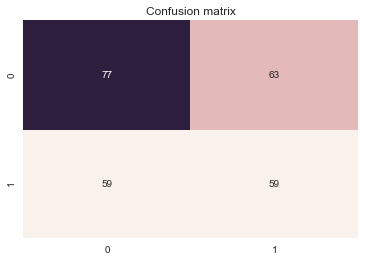

In [574]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [575]:
clf = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', verbose=5)

In [576]:
clf.fit(b, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] alpha=0.0001 ....................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 17.84, NNZs: 30, Bias: -6.272780, T: 600, Avg. loss: 3.302744
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 18.10, NNZs: 30, Bias: 0.059777, T: 1200, Avg. loss: 2.314547
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 19.47, NNZs: 30, Bias: 3.704730, T: 1800, Avg. loss: 1.871690
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 20.37, NNZs: 30, Bias: 0.206024, T: 2400, Avg. loss: 1.664928
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 18.71, NNZs: 30, Bias: 0.235639, T: 3000, Avg. loss: 1.480547
Total training time: 0.08 seconds.
[CV] ......................... alpha=0.0001, score=0.52, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.0001 ....................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 20.29, NNZs: 30, Bias: -6.175947, T: 600, Avg. loss: 3.175928
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 20.88, NNZs: 30, Bias: -4.467091, T: 1200, Avg. loss: 2.287171
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 23.39, NNZs: 30, Bias: 3.643293, T: 1800, Avg. loss: 1.940050
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 23.10, NNZs: 30, Bias: 3.047672, T: 2400, Avg. loss: 1.662640
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 21.72, NNZs: 30, Bias: -2.399268, T: 3000, Avg. loss: 1.447135
Total training time: 0.05 seconds.
[CV] ........... alpha=0.0001, score=0.5033333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=0.0001 ....................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 16.41, NNZs: 30, Bias: 6.234085, T: 600, Avg. loss: 3.248832
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 18.40, NNZs: 30, Bias: -4.513182, T: 1200, Avg. loss: 2.492977
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 20.49, NNZs: 30, Bias: 0.086791, T: 1800, Avg. loss: 1.926461
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 20.47, NNZs: 30, Bias: 3.075843, T: 2400, Avg. loss: 1.633112
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 19.43, NNZs: 30, Bias: 0.174106, T: 3000, Avg. loss: 1.589718
Total training time: 0.05 seconds.
[CV] .......... alpha=0.0001, score=0.48333333333333334, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV] alpha=0.005 .....................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.18, NNZs: 30, Bias: -0.318224, T: 600, Avg. loss: 1.157170
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.12, NNZs: 30, Bias: 0.310880, T: 1200, Avg. loss: 0.981817
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.24, NNZs: 30, Bias: 0.159338, T: 1800, Avg. loss: 1.032429
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.20, NNZs: 30, Bias: 0.722806, T: 2400, Avg. loss: 0.970712
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.24, NNZs: 30, Bias: -0.232153, T: 3000, Avg. loss: 1.016279
Total training time: 0.05 seconds.
[CV] ............ alpha=0.005, score=0.5033333333333333, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] alpha=0.005 .....................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.24, NNZs: 30, Bias: -1.215583, T: 600, Avg. loss: 1.122928
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.25, NNZs: 30, Bias: 0.202905, T: 1200, Avg. loss: 0.971798
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.41, NNZs: 30, Bias: 0.316151, T: 1800, Avg. loss: 1.014610
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 1.44, NNZs: 30, Bias: 0.487940, T: 2400, Avg. loss: 0.997067
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.48, NNZs: 30, Bias: -0.240309, T: 3000, Avg. loss: 0.982476
Total training time: 0.05 seconds.
[CV] ............ alpha=0.005, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.005 .....................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.12, NNZs: 30, Bias: 0.372174, T: 600, Avg. loss: 1.118581
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.17, NNZs: 30, Bias: -0.602534, T: 1200, Avg. loss: 1.035192
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.21, NNZs: 30, Bias: -0.182868, T: 1800, Avg. loss: 1.010796
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 1.23, NNZs: 30, Bias: 0.055237, T: 2400, Avg. loss: 0.990665
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.27, NNZs: 30, Bias: -0.553236, T: 3000, Avg. loss: 1.016087
Total training time: 0.05 seconds.
[CV] ............ alpha=0.005, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.01 ......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.67, NNZs: 30, Bias: 0.248056, T: 600, Avg. loss: 1.102257
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.62, NNZs: 30, Bias: 0.659457, T: 1200, Avg. loss: 0.963460
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.66, NNZs: 30, Bias: -0.065544, T: 1800, Avg. loss: 1.024806
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.66, NNZs: 30, Bias: 0.517926, T: 2400, Avg. loss: 0.984350
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.67, NNZs: 30, Bias: 0.311076, T: 3000, Avg. loss: 1.015651
Total training time: 0.05 seconds.
[CV] ............ alpha=0.01, score=0.49666666666666665, total=   0.0s
[CV] alpha=0.01 ......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.82, NNZs: 30, Bias: -0.767942, T: 600, Avg. loss: 1.067744
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 30, Bias: 0.592572, T: 1200, Avg. loss: 0.987215
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.82, NNZs: 30, Bias: -0.335256, T: 1800, Avg. loss: 1.014073
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.83, NNZs: 30, Bias: 0.109135, T: 2400, Avg. loss: 0.995141
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.85, NNZs: 30, Bias: -0.032087, T: 3000, Avg. loss: 1.010465
Total training time: 0.06 seconds.
[CV] ............ alpha=0.01, score=0.49333333333333335, total=   0.0s
[CV] alpha=0.01 ......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.68, NNZs: 30, Bias: 0.038294, T: 600, Avg. loss: 1.048034
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.67, NNZs: 30, Bias: -0.503024, T: 1200, Avg. loss: 1.019848
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.70, NNZs: 30, Bias: -0.521245, T: 1800, Avg. loss: 1.027841
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.70, NNZs: 30, Bias: -0.111353, T: 2400, Avg. loss: 1.004980
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.71, NNZs: 30, Bias: -0.177757, T: 3000, Avg. loss: 1.013908
Total training time: 0.05 seconds.
[CV] ............. alpha=0.01, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.05 ......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.15, NNZs: 30, Bias: -0.042534, T: 600, Avg. loss: 1.031821
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 30, Bias: -0.147930, T: 1200, Avg. loss: 1.011991
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.15, NNZs: 30, Bias: -0.197858, T: 1800, Avg. loss: 1.004912
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.15, NNZs: 30, Bias: -0.274145, T: 2400, Avg. loss: 1.002967
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.15, NNZs: 30, Bias: -0.301132, T: 3000, Avg. loss: 1.000934
Total training time: 0.05 seconds.
[CV] ............. alpha=0.05, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.05 ......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.18, NNZs: 30, Bias: -0.015212, T: 600, Avg. loss: 1.034258
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 30, Bias: -0.237119, T: 1200, Avg. loss: 1.010586
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 30, Bias: -0.296599, T: 1800, Avg. loss: 1.003703
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 30, Bias: -0.362522, T: 2400, Avg. loss: 1.001314
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 30, Bias: -0.382891, T: 3000, Avg. loss: 0.999675
Total training time: 0.05 seconds.
[CV] ............. alpha=0.05, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.05 ......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.16, NNZs: 30, Bias: -0.771956, T: 600, Avg. loss: 1.004913
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 30, Bias: -0.683260, T: 1200, Avg. loss: 1.003426
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.15, NNZs: 30, Bias: -0.702782, T: 1800, Avg. loss: 1.001735
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.15, NNZs: 30, Bias: -0.744239, T: 2400, Avg. loss: 0.999201
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.15, NNZs: 30, Bias: -0.757491, T: 3000, Avg. loss: 0.997896
Total training time: 0.05 seconds.
[CV] ............. alpha=0.05, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.1 .......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.07, NNZs: 30, Bias: -0.506457, T: 600, Avg. loss: 1.022918
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.07, NNZs: 30, Bias: -0.559319, T: 1200, Avg. loss: 1.002788
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.07, NNZs: 30, Bias: -0.584339, T: 1800, Avg. loss: 0.999224
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.07, NNZs: 30, Bias: -0.622590, T: 2400, Avg. loss: 0.998249
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.08, NNZs: 30, Bias: -0.636101, T: 3000, Avg. loss: 0.997230
Total training time: 0.05 seconds.
[CV] .............. alpha=0.1, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.1 .......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.09, NNZs: 30, Bias: -0.310046, T: 600, Avg. loss: 1.025609
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.09, NNZs: 30, Bias: -0.421830, T: 1200, Avg. loss: 1.003282
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.10, NNZs: 30, Bias: -0.451650, T: 1800, Avg. loss: 0.999824
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 0.10, NNZs: 30, Bias: -0.484700, T: 2400, Avg. loss: 0.998628
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.10, NNZs: 30, Bias: -0.494891, T: 3000, Avg. loss: 0.997809
Total training time: 0.05 seconds.
[CV] .............. alpha=0.1, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.1 .......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.08, NNZs: 30, Bias: -0.071928, T: 600, Avg. loss: 1.008671
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 30, Bias: -0.134773, T: 1200, Avg. loss: 1.005008
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.08, NNZs: 30, Bias: -0.144512, T: 1800, Avg. loss: 1.002230
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 30, Bias: -0.165284, T: 2400, Avg. loss: 1.000962
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.08, NNZs: 30, Bias: -0.171907, T: 3000, Avg. loss: 1.000315
Total training time: 0.07 seconds.
[CV] .............. alpha=0.1, score=0.5033333333333333, total=   0.0s
[CV] alpha=0.5 .......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.02, NNZs: 30, Bias: 0.196730, T: 600, Avg. loss: 1.012751
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 30, Bias: 0.186124, T: 1200, Avg. loss: 1.002545
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 30, Bias: 0.181108, T: 1800, Avg. loss: 1.001831
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 30, Bias: 0.173436, T: 2400, Avg. loss: 1.001635
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 30, Bias: 0.170730, T: 3000, Avg. loss: 1.001431
Total training time: 0.07 seconds.
[CV] ............. alpha=0.5, score=0.49666666666666665, total=   0.0s
[CV] alpha=0.5 .......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.02, NNZs: 30, Bias: 0.647525, T: 600, Avg. loss: 1.014652
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 30, Bias: 0.624995, T: 1200, Avg. loss: 1.005386
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 30, Bias: 0.619014, T: 1800, Avg. loss: 1.004692
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 30, Bias: 0.612386, T: 2400, Avg. loss: 1.004453
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 30, Bias: 0.610346, T: 3000, Avg. loss: 1.004289
Total training time: 0.05 seconds.
[CV] ............. alpha=0.5, score=0.49666666666666665, total=   0.0s
[CV] alpha=0.5 .......................................................


D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 0.02, NNZs: 30, Bias: 0.595266, T: 600, Avg. loss: 1.011969
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 30, Bias: 0.582604, T: 1200, Avg. loss: 1.005072
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 30, Bias: 0.580661, T: 1800, Avg. loss: 1.004513
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 30, Bias: 0.576498, T: 2400, Avg. loss: 1.004258
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 30, Bias: 0.575173, T: 3000, Avg. loss: 1.004128
Total training time: 0.05 seconds.
[CV] ............. alpha=0.5, score=0.49666666666666665, total=   0.0s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.3s finished
D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-- Epoch 1
Norm: 1.22, NNZs: 30, Bias: 1.078365, T: 900, Avg. loss: 1.083491
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.14, NNZs: 30, Bias: -0.485631, T: 1800, Avg. loss: 1.002422
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.16, NNZs: 30, Bias: 0.103781, T: 2700, Avg. loss: 1.025789
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 1.12, NNZs: 30, Bias: 0.052351, T: 3600, Avg. loss: 0.988375
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 1.16, NNZs: 30, Bias: -0.186706, T: 4500, Avg. loss: 1.017681
Total training time: 0.04 seconds.


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=2904,
       shuffle=True, tol=None, verbose=5, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.005, 0.01, 0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [577]:
clf.best_score_, clf.best_params_

(0.5033333333333333, {'alpha': 0.005})

In [578]:
predictions = clf.predict(d)

Precision:   0.44
Recall:   0.50
F1-measure:   0.36
Accuracy:   0.54
             precision    recall  f1-score   support

          0       0.54      0.99      0.70       140
          1       0.33      0.01      0.02       118

avg / total       0.45      0.54      0.39       258



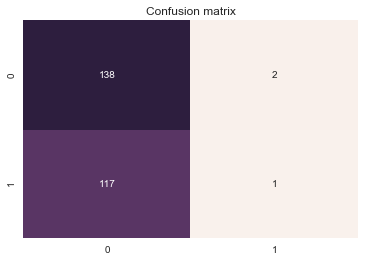

In [579]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

In [662]:
from gensim.models import ldamodel

In [708]:
from gensim.corpora import *
texts = [intersection.text.iloc[i].split() for i in range(len(intersection))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [709]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10,
                        alpha='auto', eta='auto', iterations = 20, passes = 10)

Wall time: 1min 10s


In [710]:
print('Логарифмическая перплексивность модели составляет {0}'
      .format(lda.log_perplexity(corpus)))

Логарифмическая перплексивность модели составляет -7.395395065275654


In [711]:
for idx, topic in lda.print_topics(-1):
    print('Тема:{0} Словарный состав:{1}\n'.format(idx, topic))

Тема:0 Словарный состав:0.041*"газпром" + 0.020*"нефть" + 0.016*"компания" + 0.014*"газ" + 0.010*"год" + 0.009*"месторождение" + 0.009*"который" + 0.008*"проект" + 0.007*"цена" + 0.005*"российский"

Тема:1 Словарный состав:0.042*"газпром" + 0.014*"компания" + 0.014*"газ" + 0.010*"российский" + 0.009*"который" + 0.008*"сообщать" + 0.008*"год" + 0.007*"украина" + 0.007*"поставка" + 0.006*"газовый"

Тема:2 Словарный состав:0.029*"газпром" + 0.016*"компания" + 0.010*"газ" + 0.007*"нефть" + 0.007*"сообщать" + 0.007*"цена" + 0.006*"российский" + 0.005*"который" + 0.005*"сделка" + 0.004*"проект"

Тема:3 Словарный состав:0.024*"газпром" + 0.013*"компания" + 0.010*"газ" + 0.008*"газпромбанк" + 0.008*"который" + 0.007*"сообщать" + 0.007*"год" + 0.006*"российский" + 0.005*"нефть" + 0.005*"источник"

Тема:4 Словарный состав:0.015*"газпром" + 0.007*"газ" + 0.007*"год" + 0.006*"компания" + 0.006*"который" + 0.004*"газпром-медиа" + 0.004*"цена" + 0.004*"российский" + 0.004*"холдинг" + 0.004*"телекана